<a href="https://colab.research.google.com/github/hsreekumar/ML/blob/main/Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# prompt: read events_with_outliers.json as a df

import pandas as pd

df = pd.read_json('events_with_outliers.json')


df['timestamp'] = pd.to_datetime(df['timestamp'])

# Function to round timestamps to the nearest hour based on 5-minute thresholds
def round_to_nearest_hour(ts):
    if ts.minute >= 30:
        return ts.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    else:
        return ts.replace(minute=0, second=0, microsecond=0)

# Apply rounding function
df['rounded_timestamp'] = df['timestamp'].apply(round_to_nearest_hour)

# Extract hour and date from the rounded timestamp
df['hour'] = df['rounded_timestamp'].dt.hour
df['date'] = df['rounded_timestamp'].dt.date

print(df.describe())

               hour
count  61209.000000
mean      13.886030
std        5.727974
min        0.000000
25%       10.000000
50%       16.000000
75%       18.000000
max       23.000000


In [24]:
!pip install kneed
!pip install scipy

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

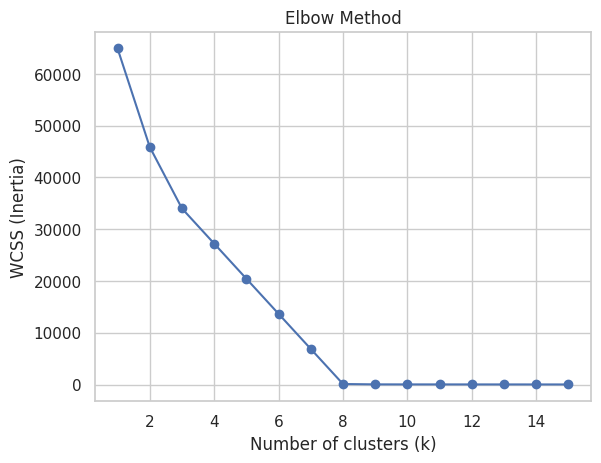

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


df['timestamp'] = pd.to_datetime(df['timestamp'])

# Function to round timestamps to the nearest hour based on 5-minute thresholds
def round_to_nearest_hour(ts):
    if ts.minute >= 30:
        return ts.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    else:
        return ts.replace(minute=0, second=0, microsecond=0)

# Apply rounding function
df['rounded_timestamp'] = df['timestamp'].apply(round_to_nearest_hour)

# Extract hour and date from the rounded timestamp
df['hour'] = df['rounded_timestamp'].dt.hour
df['date'] = df['rounded_timestamp'].dt.date

# print(df.head(25))

# Group by date, hour, event_type, event_source, identifier, count occurrences
grouped = df.groupby(['hour', 'event_type', 'event_source', 'identifier']).size().reset_index(name='count')

grouped_sorted = grouped.sort_values(by='count', ascending=False)


# Prepare the data
X = grouped_sorted[['hour', 'count']]


# Scale the data using StandardScaler
scaler = OneHotEncoder(sparse=False)
X_scaled = scaler.fit_transform(X)

# Apply KMeans and the elbow method
wcss = []
max_clusters = 15  # We know we're targeting around 9 clusters

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled, sample_weight=grouped_sorted['count'])  # Use count as a weight
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

In [207]:
# Define the number of clusters (can use the elbow method or a pre-determined number)
num_clusters = 8  # For example, this value can come from the elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_scaled, sample_weight=grouped_sorted['count'])  # Use count as a weight

# Get the scaled centroids
centroids_scaled = kmeans.cluster_centers_

# Inverse transform the centroids back to the original scale (for hour and count)
centroids_original = scaler.inverse_transform(centroids_scaled)

# Convert the centroids to a DataFrame for better interpretation
centroids_df = pd.DataFrame(centroids_original, columns=['hour', 'count'])

# Now we need to find the most frequent (mode) event_type, event_source, and identifier for each cluster
grouped_sorted['cluster'] = kmeans.labels_

# For each cluster, find the most common categorical values
centroid_event_type = grouped_sorted.groupby('cluster')['event_type'].agg(lambda x: x.mode()[0])
centroid_event_source = grouped_sorted.groupby('cluster')['event_source'].agg(lambda x: x.mode()[0])
centroid_identifier = grouped_sorted.groupby('cluster')['identifier'].agg(lambda x: x.mode()[0])

# Add the most common categorical values to the centroids DataFrame
centroids_df['event_type'] = centroid_event_type.values
centroids_df['event_source'] = centroid_event_source.values
centroids_df['identifier'] = centroid_identifier.values

# Print the final centroids DataFrame
print(centroids_df)

   hour  count event_type event_source identifier
0    18   6785          A            D          E
1    22   6786          A            B          C
2    10   6785          A            D          E
3     5   6785          A            F          G
4    11   6785          A            B          C
5     6   6785          A            H          I
6    16   6785          A            B          C
7    19   6785          A            H          I


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

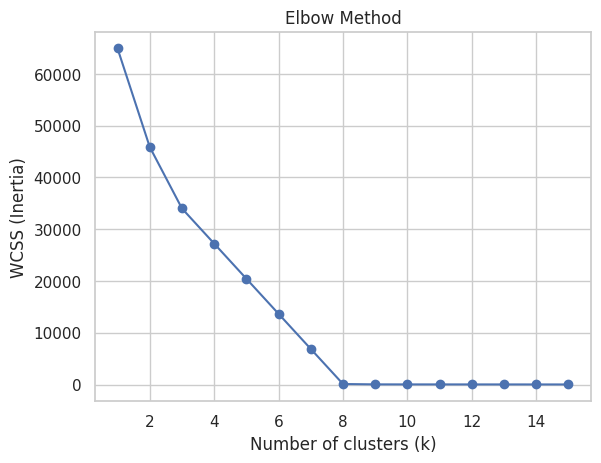

Optimal number of clusters (k): 9
   hour   count event_type event_source identifier
0     5  3392.5          A            F          G
1    22  3393.0          A            F          G
2    18  3392.5          A            D          E
3    10  3392.5          A            D          E
4    11  3392.5          A            B          C
5     6  3392.5          A            H          I
6    16  3392.5          A            B          C
7    19  3392.5          A            H          I
8    20     0.5          A            D          E


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Prepare the data
X = grouped_sorted[['hour', 'count']]

# Scale the data using StandardScaler
scaler = OneHotEncoder(sparse=False)

# Apply more weight to the 'count' feature by multiplying it with a factor
weight_factor = 2  # Increase this to give more weight to count
X_scaled = X.copy()
X_scaled['count'] = X['count'] * weight_factor
X_scaled = scaler.fit_transform(X)

# Apply KMeans and calculate inertia (WCSS) for different cluster sizes
wcss = []
max_clusters = 15  # Try cluster values up to 15

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled, sample_weight=grouped_sorted['count'])  # Use sample weights
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

# Find the optimal k where the curve flattens
def calculate_optimal_k(wcss):
    first_diff = np.diff(wcss)
    second_diff = np.diff(first_diff)

    flatten_threshold = 80  # Adjust this threshold as needed
    optimal_k = np.where(np.abs(first_diff) < flatten_threshold)[0]

    if len(optimal_k) > 0:
        return optimal_k[0] + 2  # +2 because np.diff reduces dimension
    else:
        return None  # No optimal k found

# Calculate optimal k using the formula
optimal_k = calculate_optimal_k(wcss)

if optimal_k is not None:
    print(f"Optimal number of clusters (k): {optimal_k}")
else:
    print("No optimal k found based on the flattening condition.")

# Now apply KMeans with the optimal number of clusters if found
if optimal_k is not None:
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans_optimal.fit(X_scaled, sample_weight=grouped_sorted['count'])  # Use sample weights

    # Assign clusters to the data
    grouped_sorted['cluster'] = kmeans_optimal.labels_

    # Print the cluster centroids in terms of original features
    centroids_scaled = kmeans_optimal.cluster_centers_
    centroids_original = scaler.inverse_transform(centroids_scaled)

    # Convert centroids to DataFrame for readability
    centroids_df = pd.DataFrame(centroids_original, columns=['hour', 'count'])
    centroids_df['count'] = centroids_df['count'] / weight_factor  # Reverse the scaling of 'count'

    # Add most common event_type, event_source, identifier for each cluster
    centroid_event_type = grouped_sorted.groupby('cluster')['event_type'].agg(lambda x: x.mode()[0])
    centroid_event_source = grouped_sorted.groupby('cluster')['event_source'].agg(lambda x: x.mode()[0])
    centroid_identifier = grouped_sorted.groupby('cluster')['identifier'].agg(lambda x: x.mode()[0])

    # Add categorical data to centroids DataFrame
    centroids_df['event_type'] = centroid_event_type.values
    centroids_df['event_source'] = centroid_event_source.values
    centroids_df['identifier'] = centroid_identifier.values

    # Print the final centroids
    print(centroids_df)

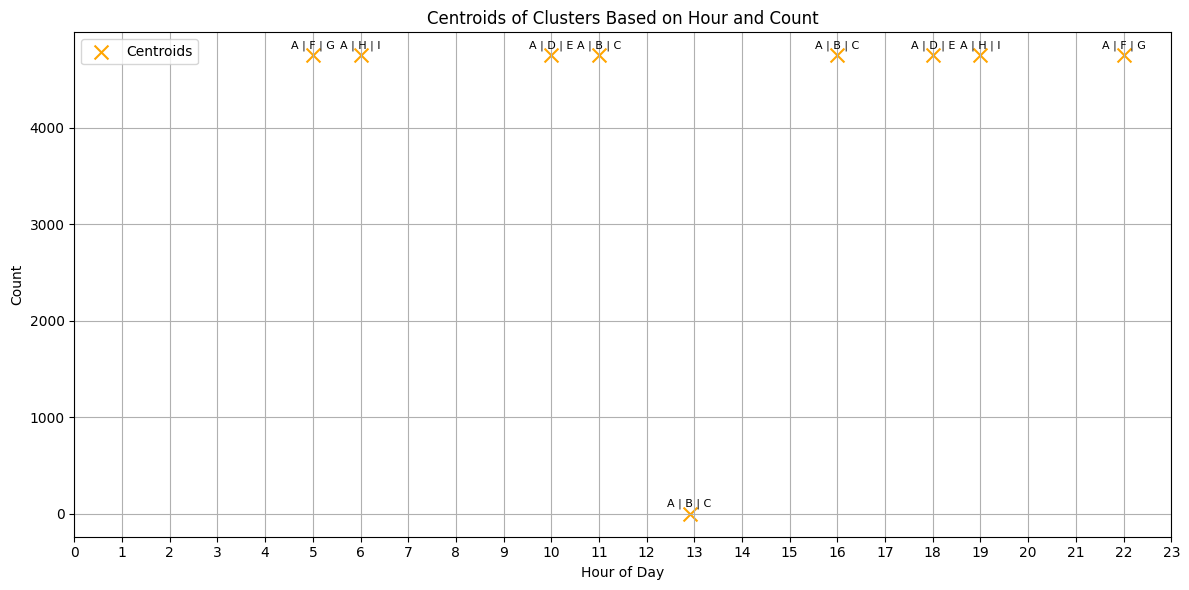

In [120]:
import matplotlib.pyplot as plt

# Assuming 'centroids_df' contains the centroid information

# Create a scatter plot for the centroids
plt.figure(figsize=(12, 6))
plt.scatter(centroids_df['hour'], centroids_df['count'], color='orange', label='Centroids', marker='x', s=100)

# Annotate each centroid with event_type, event_source, and identifier
for i in range(len(centroids_df)):
    plt.annotate(f"{centroids_df['event_type'][i]} | {centroids_df['event_source'][i]} | {centroids_df['identifier'][i]}",
                 (centroids_df['hour'][i], centroids_df['count'][i]),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center', fontsize=8)

plt.title('Centroids of Clusters Based on Hour and Count')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(24))
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Outlier Threshold: 0.11819040329659418


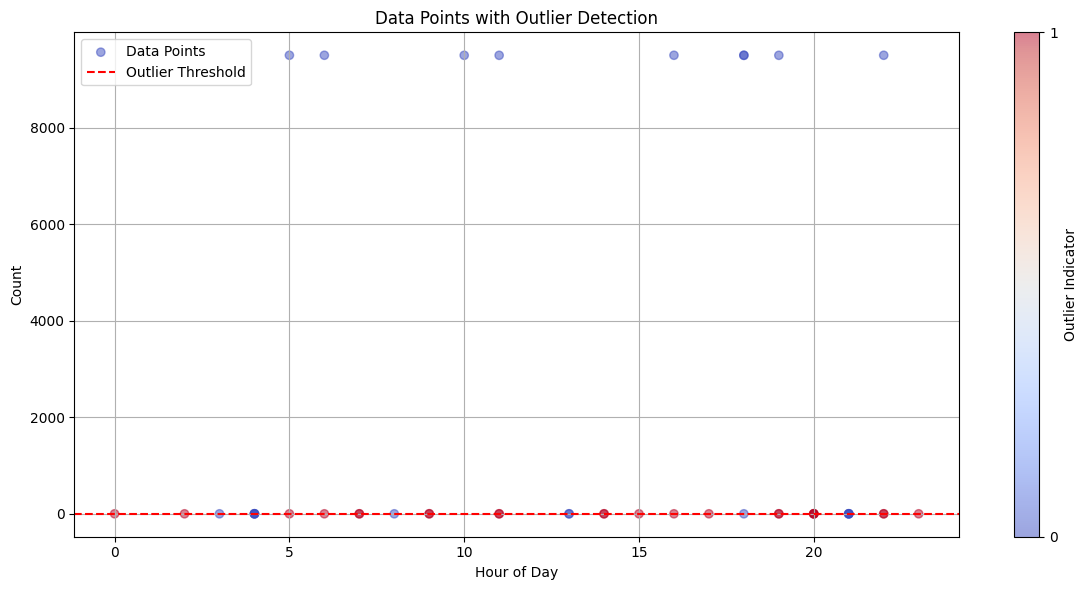

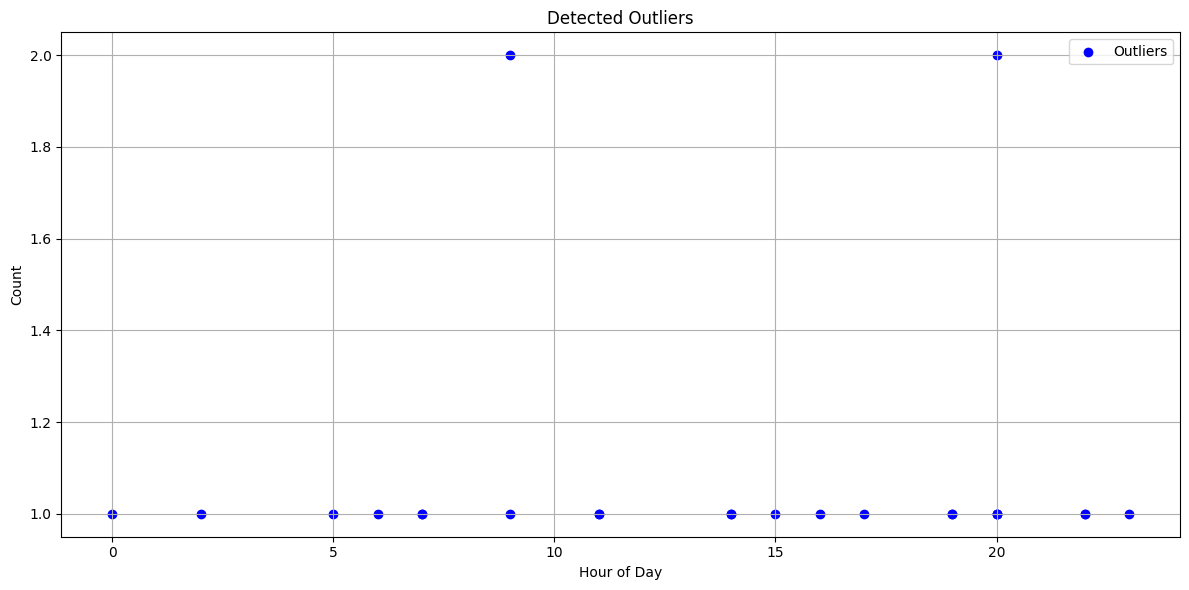

Distances to Centroids:
[0.00000000e+00 0.00000000e+00 1.32673222e-04 4.21468485e-08
 0.00000000e+00 0.00000000e+00 1.32687192e-04 0.00000000e+00
 4.21468485e-08 9.85320138e-02 1.68911759e-01 1.35481402e-01
 2.95595393e-02 1.77357236e-01 1.77357236e-01 1.35481229e-01
 4.92658992e-01 1.18238157e-01 1.35481229e-01 1.23165541e-02
 1.23165541e-02 1.23165541e-02 1.23165541e-02 1.60114177e-01
 1.60114177e-01 1.35481229e-01 1.47797696e-01 2.66035854e-01
 1.26683762e-01 4.92659341e-02 9.85318152e-02 9.85318152e-02
 9.85318152e-02 2.46329501e-01 2.74481447e-01 1.26683762e-01
 2.11140928e-02 2.95595393e-01 1.68911670e-01 2.95595393e-01
 2.95595393e-01 0.00000000e+00 0.00000000e+00 1.47797696e-01
 1.97063604e-01 3.07911871e-01]


In [125]:

    # Calculate distances to centroids
    distances = kmeans_optimal.transform(X_scaled).min(axis=1)

    # Define a threshold for outliers (mean + std)
    threshold = np.mean(distances)
    print(f"Outlier Threshold: {threshold}")

    # Identify outliers
    outliers = distances > threshold

    # Plot all data points and highlight outliers
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(grouped_sorted['hour'], grouped_sorted['count'],
                          c=outliers, cmap='coolwarm', alpha=0.5, label='Data Points')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Outlier Threshold')
    plt.title('Data Points with Outlier Detection')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.colorbar(scatter, ticks=[0, 1], label='Outlier Indicator')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot only the outliers
    outlier_points = grouped_sorted[outliers]
    plt.figure(figsize=(12, 6))
    plt.scatter(outlier_points['hour'], outlier_points['count'], color='blue', label='Outliers')
    plt.title('Detected Outliers')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Print distances for analysis
    print("Distances to Centroids:")
    print(distances)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


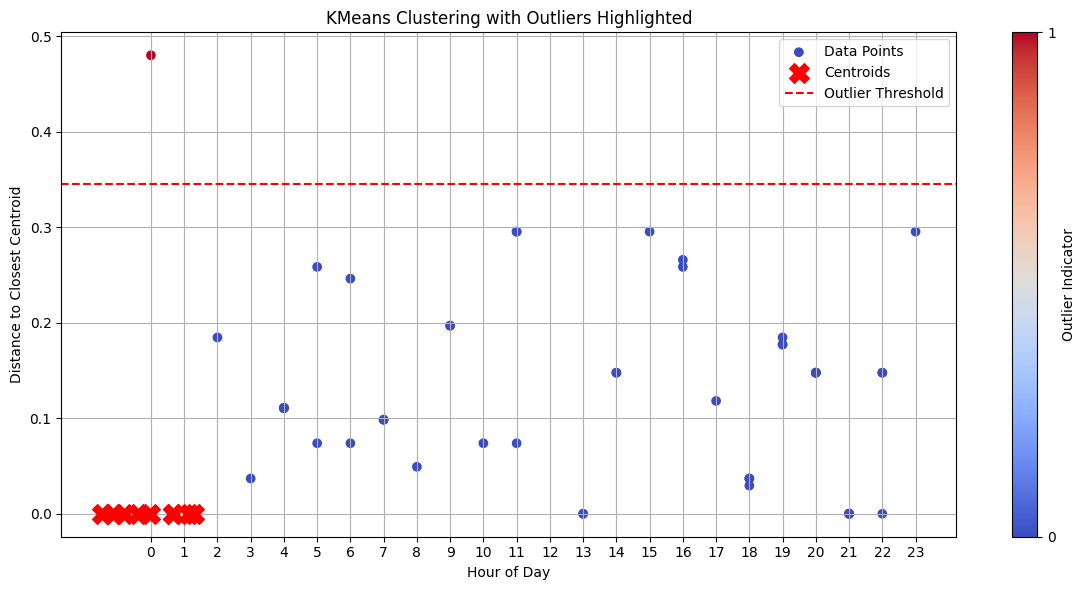

    hour event_type event_source identifier  count  cluster  distance  outlier
25    16          A            B          C   9501        1  0.258646    False
44    22          A            F          G   9501        8  0.000000    False
29    18          A            D          E   9501        1  0.036950    False
7      5          A            F          G   9501        4  0.073899    False
10     6          A            H          I   9501        4  0.073899    False
16    10          A            D          E   9500        6  0.073899    False
30    18          A            J          K   9500        1  0.036950    False
33    19          A            H          I   9500        1  0.184747    False
17    11          A            B          C   9500        6  0.073899    False
5      4          A            H          I      2        2  0.110849    False
14     9          A            D          E      2        5  0.197064    False
35    20          A            D          E      2  

In [126]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Convert timestamps to datetime (make sure to parse timezone info)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Function to round timestamps to the nearest hour based on 5-minute thresholds
def round_to_nearest_hour(ts):
    if ts.minute >= 30:
        return ts.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    else:
        return ts.replace(minute=0, second=0, microsecond=0)

# Apply rounding function
df['rounded_timestamp'] = df['timestamp'].apply(round_to_nearest_hour)

# Extract hour and date from the rounded timestamp
df['hour'] = df['rounded_timestamp'].dt.hour
df['date'] = df['rounded_timestamp'].dt.date

# Group by hour, event_type, event_source, identifier, count occurrences
grouped = df.groupby(['hour', 'event_type', 'event_source', 'identifier']).size().reset_index(name='count')

# Sort grouped data by count in descending order
grouped_sorted = grouped.sort_values(by='count', ascending=False)

# Prepare data for clustering
X = grouped_sorted[['hour', 'count']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set the number of clusters to 9 (as expected)
num_clusters = 9

# Fit KMeans with the specified number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
grouped_sorted['cluster'] = kmeans.fit_predict(X_scaled)

# Get distances to centroids
distances = kmeans.transform(X_scaled)
grouped_sorted['distance'] = np.min(distances, axis=1)

# Define a threshold for outliers (mean + 2 * std deviation)
threshold = grouped_sorted['distance'].mean() + 2 * grouped_sorted['distance'].std()

# Identify outliers
grouped_sorted['outlier'] = grouped_sorted['distance'] > threshold

# Calculate centroids for plotting
centroids = kmeans.cluster_centers_
centroid_hours = centroids[:, 0]
centroid_counts = [grouped_sorted[grouped_sorted['cluster'] == i]['count'].mean() for i in range(num_clusters)]

# Plot outliers and centroids
plt.figure(figsize=(12, 6))

# Scatter plot for outliers
scatter = plt.scatter(grouped_sorted['hour'], grouped_sorted['distance'],
                      c=grouped_sorted['outlier'].apply(lambda x: 1 if x else 0),
                      cmap='coolwarm', marker='o', label='Data Points')

# Scatter plot for centroids
plt.scatter(centroid_hours, [0] * len(centroid_hours),
            color='red', marker='X', s=200, label='Centroids', zorder=5)

# Draw a horizontal line for the outlier threshold
plt.axhline(y=threshold, color='r', linestyle='--', label='Outlier Threshold')

# Set plot title and labels
plt.title('KMeans Clustering with Outliers Highlighted')
plt.xlabel('Hour of Day')
plt.ylabel('Distance to Closest Centroid')
plt.xticks(range(24))
plt.colorbar(scatter, ticks=[0, 1], label='Outlier Indicator')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Show grouped sorted data with cluster and outlier information
print(grouped_sorted)

In [194]:
import pandas as pd
import numpy as np



df['timestamp'] = pd.to_datetime(df['timestamp'])

# Function to round timestamps to the nearest hour based on 5-minute thresholds
def round_to_nearest_hour(ts):
    if ts.minute >= 30:
        return ts.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    else:
        return ts.replace(minute=0, second=0, microsecond=0)

# Apply rounding function
df['rounded_timestamp'] = df['timestamp'].apply(round_to_nearest_hour)

# Extract hour and date from the rounded timestamp
df['hour'] = df['rounded_timestamp'].dt.hour
df['date'] = df['rounded_timestamp'].dt.date

# print(df.head(25))

# Group by date, hour, event_type, event_source, identifier, count occurrences
grouped = df.groupby(['hour', 'event_type', 'event_source', 'identifier']).size().reset_index(name='count')

grouped_sorted = grouped.sort_values(by='count', ascending=False)

# Print the sorted DataFrame
print(grouped_sorted)


# Calculate mean and standard deviation of counts for the relevant group
mean_count = grouped['count'].mean()
std_count = grouped['count'].std()

# Define threshold for outlier detection
k =  1 # Adjust this value as needed
threshold = mean_count + k * std_count
#threshold =10

print(f"Mean Count: {mean_count}, Standard Deviation: {std_count}, Outlier Threshold: {threshold}")
# New event for testing
new_event = {
    "event_type": "A",
    "event_source": "B",
    "identifier": "C",
    "timestamp": "2024-03-12T11:50:00.000Z"
}
new_event_df = pd.DataFrame([new_event])
new_event_df['timestamp'] = pd.to_datetime(new_event_df['timestamp'])
new_event_df['timestamp'] = pd.to_datetime(new_event_df['timestamp'])


# Apply rounding function
new_event_df['rounded_timestamp'] = new_event_df['timestamp'].apply(round_to_nearest_hour)

# Extract hour and date from the rounded timestamp
new_event_df['hour'] = new_event_df['rounded_timestamp'].dt.hour

print(new_event_df)
# Check the count for the new event
new_hour_grouped = new_event_df.groupby(['hour', 'event_type', 'event_source', 'identifier']).size().reset_index(name='count')

# Combine historical and new event counts for the same group
for _, row in new_hour_grouped.iterrows():
    print(f"Checking event {row['event_type']} from {row['event_source']} with identifier {row['identifier']} at {row['hour']}")
    # Find historical count for the same group
    historical_count = grouped[
        (grouped['hour'] == row['hour']) &
        (grouped['event_type'] == row['event_type']) &
        (grouped['event_source'] == row['event_source']) &
        (grouped['identifier'] == row['identifier'])
    ]['count'].sum()

    total_count = historical_count + row['count']
    print(f"Historical Count: {historical_count}, New Count: {row['count']}, Total Count: {total_count}")
    is_outlier = total_count < threshold

    print(f"New event {row['event_type']} from {row['event_source']} with identifier {row['identifier']} "
          f"at {row['hour']} is {'an outlier' if is_outlier else 'not an outlier'}.")

    hour event_type event_source identifier  count
32    22          A            F          G   6786
24    18          A            D          E   6785
21    16          A            B          C   6785
5      5          A            F          G   6785
15    11          A            B          C   6785
7      6          A            H          I   6785
13    10          A            D          E   6785
26    19          A            H          I   6785
25    18          A            J          K   6785
27    20          A            B          C      2
22    17          A            H          I      1
23    17          A            J          K      1
0      0          A            D          E      1
19    15          A            F          G      1
28    20          A            D          E      1
29    21          A            D          E      1
30    21          A            F          G      1
31    22          A            B          C      1
20    15          A            

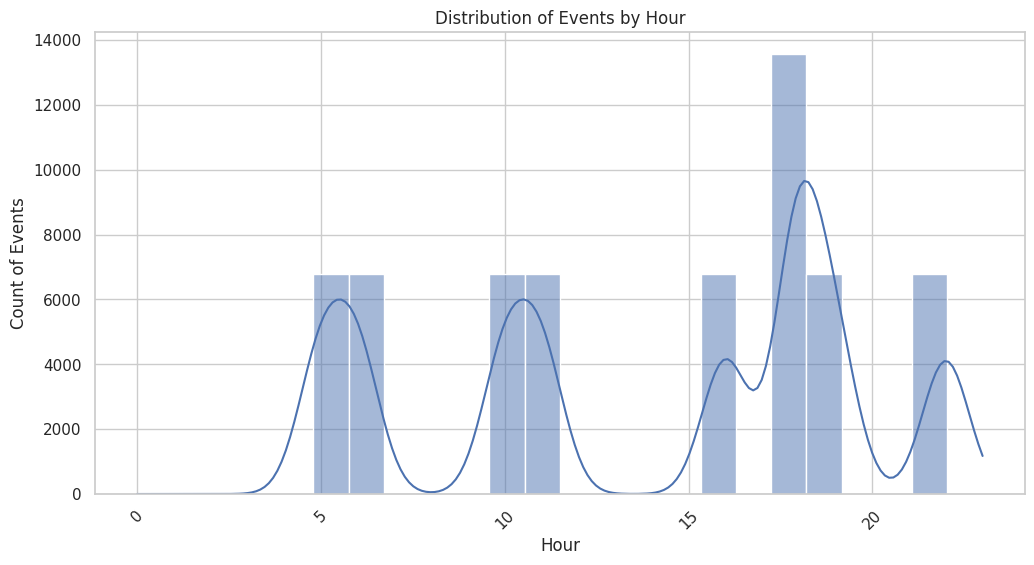

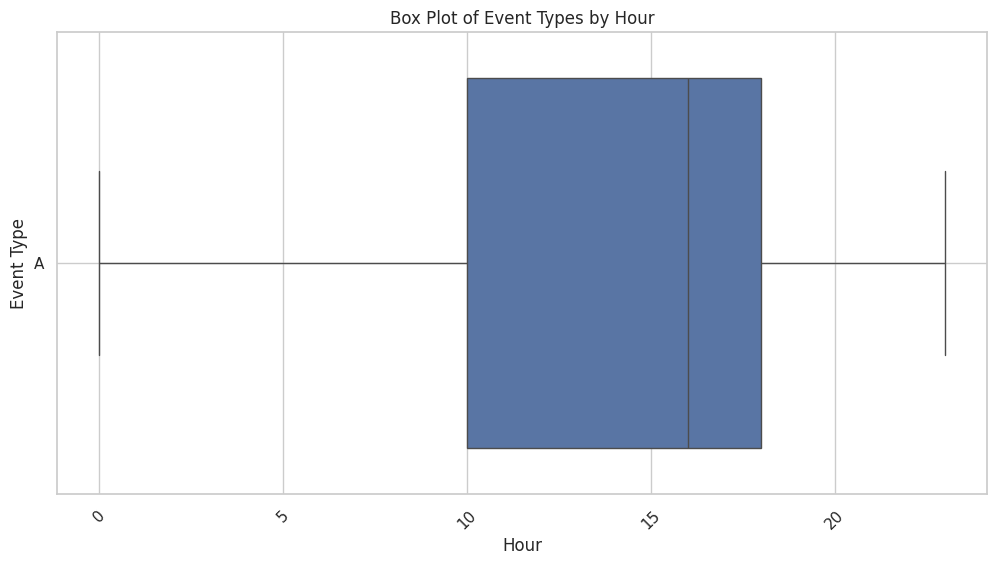

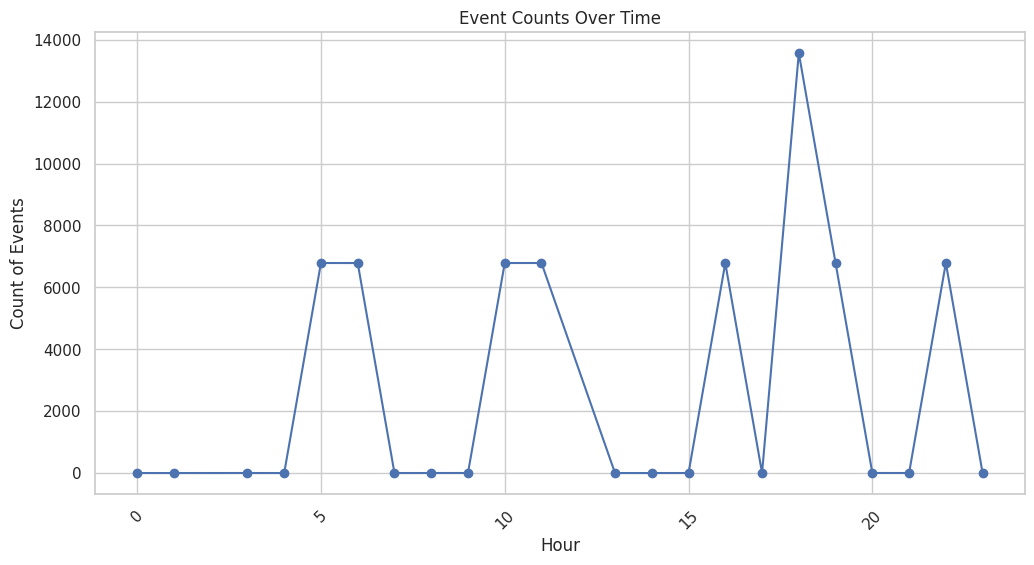

Summary Statistics:
               hour
count  61092.000000
mean      13.888283
std        5.724910
min        0.000000
25%       10.000000
50%       16.000000
75%       18.000000
max       23.000000

Percentiles:
      hour
0.25  10.0
0.50  16.0
0.75  18.0


In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Set the visual style
sns.set(style='whitegrid')

# Visualization: Histogram of Events by Hour
plt.figure(figsize=(12, 6))
sns.histplot(df['hour'], bins=24, kde=True)
plt.title('Distribution of Events by Hour')
plt.xlabel('Hour')
plt.ylabel('Count of Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualization: Box Plot of Event Types by Hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='event_type', data=df)
plt.title('Box Plot of Event Types by Hour')
plt.xlabel('Hour')
plt.ylabel('Event Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualization: Time Series Plot of Event Counts
event_counts = df.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
plt.plot(event_counts['hour'], event_counts['count'], marker='o')
plt.title('Event Counts Over Time')
plt.xlabel('Hour')
plt.ylabel('Count of Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Summary Statistics
summary_stats = df.describe()
print("Summary Statistics:")
print(summary_stats)

# Percentiles for specific features
# Percentiles for specific features
percentiles = df[['hour']].quantile([0.25, 0.5, 0.75]) # Removed 'event_type' column
print("\nPercentiles:")
print(percentiles)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

Optimal k determined: 9


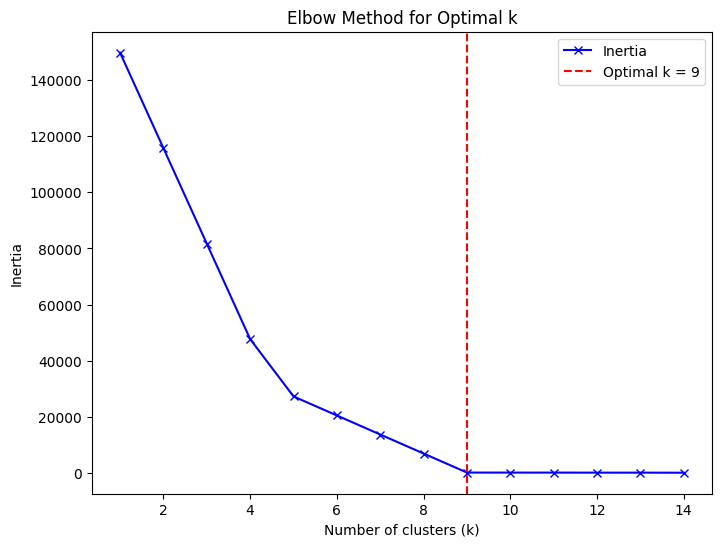

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


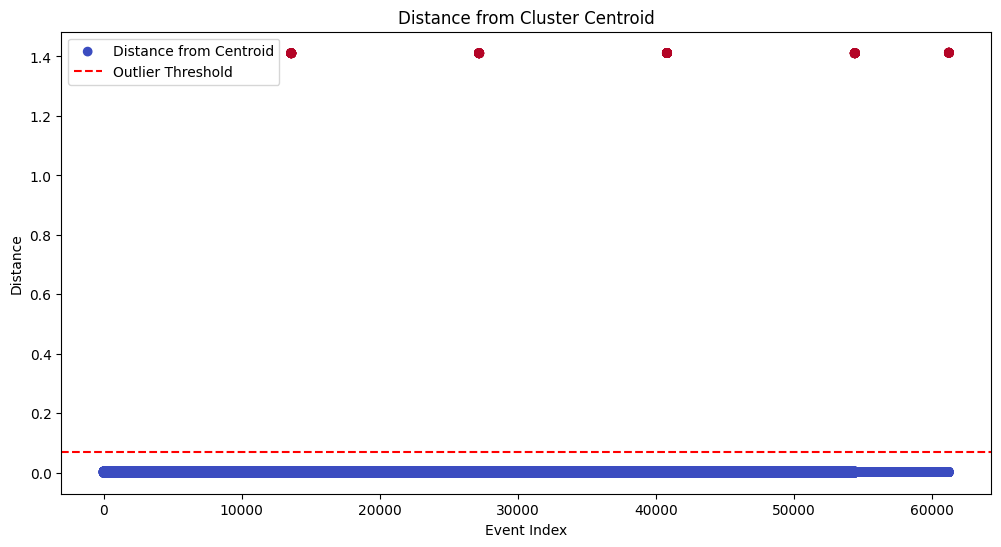

Detected outliers:
      event_type event_source identifier                 timestamp  is_outlier
13572          A            B          C 2024-09-23 00:23:00+00:00        True
13573          A            B          C 2024-09-23 17:37:00+00:00        True
13574          A            B          C 2024-09-23 21:32:00+00:00        True
13575          A            B          C 2024-09-23 03:43:00+00:00        True
13576          A            B          C 2024-09-23 00:50:00+00:00        True
...          ...          ...        ...                       ...         ...
61203          A            J          K 2024-09-20 09:04:00+00:00        True
61204          A            J          K 2024-09-19 14:24:00+00:00        True
61205          A            J          K 2024-09-19 05:10:00+00:00        True
61206          A            J          K 2024-09-19 21:07:00+00:00        True
61208          A            J          K 2024-09-19 12:47:00+00:00        True

[125 rows x 5 columns]


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['event_type', 'event_source', 'identifier', 'hour']])

# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 15)  # Test different k values (you can extend the range as needed)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_features)
    inertia.append(kmeans.inertia_)

# Smooth the inertia curve to reduce noise
smoothed_inertia = gaussian_filter1d(inertia, sigma=5.0)

# Calculate the first differences
first_diff = np.diff(smoothed_inertia)

# Define a dynamic threshold for determining when the curve flattens
flatten_threshold = np.mean(np.abs(first_diff)) * 0.1  # 10% of mean first_diff

# Find the optimal k based on flattening of the curve
optimal_k = np.where(np.abs(first_diff) < flatten_threshold)[0]

if len(optimal_k) > 0:
    optimal_k = optimal_k[0] + 2  # +2 to account for the dimension reduction caused by np.diff
    print(f"Optimal k determined: {optimal_k}")
else:
    optimal_k = 9  # Default value if no flattening detected

print(f"Optimal k determined: {optimal_k}")

# Plotting the Elbow Method with the optimal k marked
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-', label='Inertia')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

# Perform KMeans clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(encoded_features)

# Get cluster centroids and labels
centroids = kmeans.cluster_centers_

# Convert centroids back to a DataFrame for easier interpretation
centroids_df = pd.DataFrame(centroids, columns=encoder.get_feature_names_out())
#print("Centroids of clusters:")
#print(centroids_df)
df['cluster'] = kmeans.labels_

# Calculate distances from each point to the nearest centroid
distances = pairwise_distances_argmin_min(encoded_features, centroids)[1]

# Define a distance threshold for identifying outliers
distance_threshold = np.mean(distances) + 1 * np.std(distances)

# Flag potential outliers
df['is_outlier'] = distances > distance_threshold

# Plotting clusters and outliers
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), distances, c=df['is_outlier'], cmap='coolwarm', label='Distance from Centroid')
plt.axhline(y=distance_threshold, color='r', linestyle='--', label='Outlier Threshold')
plt.title('Distance from Cluster Centroid')
plt.xlabel('Event Index')
plt.ylabel('Distance')
plt.legend()
plt.show()

# Print outlier events
outliers = df[df['is_outlier']]
print("Detected outliers:")
print(outliers[['event_type', 'event_source', 'identifier', 'timestamp', 'is_outlier']])

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

# Sample input event
new_event = {
    'event_type': 'A',
    'event_source': 'B',
    'identifier': 'C',
    'timestamp': '2024-09-21T16:35:00.000Z'
}



# Create a DataFrame for the new event (as required by OneHotEncoder)
new_event_df = pd.DataFrame([new_event])
new_event_df['timestamp'] = pd.to_datetime(new_event_df['timestamp'])


# Apply rounding function
new_event_df['rounded_timestamp'] = new_event_df['timestamp'].apply(round_to_nearest_hour)

# Extract hour and date from the rounded timestamp
new_event_df['hour'] = new_event_df['rounded_timestamp'].dt.hour
new_event_df['date'] = new_event_df['rounded_timestamp'].dt.date

# One-hot encode the new event using the same encoder
new_event_encoded = encoder.transform(new_event_df[['event_type', 'event_source', 'identifier', 'hour']])

# Calculate the distance of the new event to the nearest centroid
_, new_event_distance = pairwise_distances_argmin_min(new_event_encoded, centroids)

# Check if the new event is an outlier
is_outlier = new_event_distance[0] > distance_threshold

print(f"Distance of the new event from the nearest centroid: {new_event_distance[0]}")
print(f"Is the new event an outlier? {'Yes' if is_outlier else 'No'}")

Distance of the new event from the nearest centroid: 1.4110003442456773
Is the new event an outlier? Yes
